# Week 1 Challenge Project Template

You are not required to use this template, but we are providing it for your reference to help get you started and stay organized!  We recommend that you define functions for each step to make it easier to track what's going on in the code (especially if different team members are working on different pieces of the project).

Most of the functions provided are just examples!  Feel free to replace them with something better!  This is just a minimum working example.

## 1. Load the data

In [21]:
import pandas as po
import numpy as np

!pip install graphviz 
!apt-get install graphviz

import graphviz


%matplotlib inline

# for i in range(0,1000):
#  print("This is so sad...\n Alexa can we get 1000 likes")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
train_url = "https://raw.githubusercontent.com/BeaverWorksMedlytics/datasets/master/allhypo.train.data.csv"
test_url = "https://raw.githubusercontent.com/BeaverWorksMedlytics/datasets/master/allhypo.test.data.csv"

data_train = po.read_csv(train_url) 
data_test = po.read_csv(test_url)   # this will not have a 'class' column!

# identify columns by what time of data they hold
numeric_columns=list(["Age","TSH","T3","TT4","T4u","FTI"])

# categorical columns are everything else (minus 'class')
categorical_columns = list(set(data_train.columns)-set(numeric_columns)-set(['class']))

## 2. Format your class labels
Turn multi-classes into binary classes

In [23]:
def format_class_labels(df):
    
    import re 
    
    # regex the weird class labels out
    regex_pattern = ( "\.\|\d+")

    for index, row in df.iterrows():

        # substitute instances of our regex_pattern for an empty string
        new_class = re.sub(regex_pattern, '', row['class'])
        df.loc[index,'class']=new_class
    
    # set all negative class labels to 0, all others to 1

    df['class'] = df['class'].replace('negative', 0)                    
    df['class'] = df['class'].replace('compensated hypothyroid', 1)     
    df['class'] = df['class'].replace('primary hypothyroid', 1)         
    df['class'] = df['class'].replace('secondary hypothyroid', 1)
    
    return df

data_train = format_class_labels(data_train)
data_train.head(5)

,Age,Sex,On thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4u,FTI measured,FTI,TBG measured,TBG,referral source,class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,0
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,0
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,0
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,0
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,0


## 3. Split training into training and validation
Choose what split you like (alternatively, you can do k-fold cross validation)

In [0]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data_train, test_size=0.20, random_state=0, stratify=data_train['class'])

## 4. Clean/format the data
Note: removing rows is probably a bad idea because you won't be able to do this to the test data!  Try to come up with some clever ways to handle the "?" values.

In [0]:
# change all ?s to 0
from sklearn import preprocessing

def handle_questions(df):
  df.replace('?',np.nan, inplace=True)
  df[numeric_columns] = df[numeric_columns].apply(po.to_numeric)
  imp = preprocessing.Imputer(missing_values='NaN', strategy='median', axis=0)
  df[numeric_columns] = imp.fit_transform(df[numeric_columns])
  return df


# Make sure you do the same thing to train & val so the data is all formatted the same
data_train = handle_questions(data_train)
data_val = handle_questions(data_val)
data_test = handle_questions(data_test)

In [26]:
data_train.head()

,Age,Sex,On thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4u,FTI measured,FTI,TBG measured,TBG,referral source,class
170,70.0,M,f,f,f,t,f,f,f,f,...,t,144.0,t,1.20,t,120.0,f,NaN,SVHD,0
998,32.0,F,f,f,f,f,f,f,f,f,...,f,104.0,f,0.98,f,107.0,f,NaN,other,0
2687,57.0,M,f,f,f,f,f,f,f,f,...,t,117.0,t,0.97,t,120.0,f,NaN,other,0
2256,51.0,M,f,f,f,f,f,f,f,f,...,t,72.0,t,0.84,t,85.0,f,NaN,SVI,0
444,49.0,F,f,f,f,f,f,f,f,f,...,t,100.0,t,0.93,t,108.0,f,NaN,SVHC,0


In [0]:
def get_uninformative_columns(df):
    
    drop_columns = []
    
    for col in df.columns:
        
        # if this column has only one value, we can't learn anything from it
        if(len(df[col].unique()) == 1):
            drop_columns.append(col)
            
    return drop_columns


# drop the uninformative features
drop_columns = get_uninformative_columns(data_train)

# Make sure you do the same thing to train & val
data_train=data_train.drop(drop_columns,axis=1)
data_val=data_val.drop(drop_columns,axis=1)
data_test=data_test.drop(drop_columns,axis=1)

In [0]:
def format_data(df, numeric_columns):

    # convert numeric columns from strings to numbers
    df[numeric_columns] = df[numeric_columns].apply(po.to_numeric)    

    categorical_columns = list(set(df.columns)-set(numeric_columns))

    # convert categorical columns to indicator (0,1) variables
    for col in categorical_columns:
        
        try:
            df[col] = po.get_dummies(df[col],drop_first=True)
        except Exception as e:
            print(e)

    return df



# Make sure you do the same thing to train & val
data_train = format_data(data_train, numeric_columns)
data_val = format_data(data_val, numeric_columns)
data_test = format_data(data_test, numeric_columns)

In [29]:
def Alexa(str):
  if str == "This is so sad":
    print("Playing Despacito")
  elif str == "This is so happy":
    print("Playing Every Time We Touch by Kascada")
  
Alexa("This is so sad")
Alexa("This is so happy")

Playing Despacito
Playing Every Time We Touch by Kascada


In [9]:
data_train.head(20)

,Age,Sex,On thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,T3 measured,T3,TT4 measured,TT4,T4U measured,T4u,FTI measured,FTI,referral source,class
170,70.0,1,0,0,0,1,0,0,0,0,...,1,2.6,1,144.0,1,1.20,1,120.0,0,0
998,32.0,0,0,0,0,0,0,0,0,0,...,0,2.0,0,104.0,0,0.98,0,107.0,0,0
2687,57.0,1,0,0,0,0,0,0,0,0,...,1,3.0,1,117.0,1,0.97,1,120.0,0,0
2256,51.0,1,0,0,0,0,0,0,0,0,...,1,2.3,1,72.0,1,0.84,1,85.0,0,0
444,49.0,0,0,0,0,0,0,0,0,0,...,1,2.2,1,100.0,1,0.93,1,108.0,1,0
2179,69.0,0,0,0,0,0,0,0,0,0,...,1,1.8,1,92.0,0,0.98,0,107.0,0,0
2618,58.0,0,0,0,0,0,0,0,0,0,...,1,2.2,1,96.0,1,0.86,1,111.0,0,0
14,28.0,1,0,0,0,0,0,0,0,0,...,1,1.8,1,109.0,1,0.91,1,119.0,1,0
89,49.0,0,0,0,0,0,0,0,0,0,...,1,0.3,1,32.0,1,0.53,1,60.0,0,0
2035,64.0,0,1,0,0,0,0,0,0,0,...,1,1.4,1,85.0,1,1.18,1,71.0,0,0


## 5. Define and Train the Model
You might want to consider having one process for training on one dataset and evaluating on another.  That way you can use the same code for your train/validation as you do for your train/test

In [0]:
#ORIGINAL

"""def my_classifier_predictions(data_train, data_predict):

    feature_columns = list(set(data_train.columns)-set(['class']))

    X_train = data_train[feature_columns]
    y_train = data_train['class']
    
    X_val = data_predict[feature_columns]
    
    # For now, we'll just do logistic regression
    from sklearn.linear_model import LogisticRegression
    lr_model = LogisticRegression()

    # fit the model to training data 
    lr_model.fit(X_train, y_train)

    # apply the model to evaluation data
    y_proba = lr_model.predict_proba(X_val)
    
    return y_proba"""

In [0]:
# Predict on validation data
#y_val_proba = my_classifier_predictions(data_train, data_val)


In [0]:
#define the classifier before inputting into function
def classifier_predictions(clf, data_train, data_predict):

    feature_columns = list(set(data_train.columns)-set(['class']))

    X_train = data_train[feature_columns]
    y_train = data_train['class']
    
    X_val = data_predict[feature_columns]

    # fit the model to training data 
    clf.fit(X_train, y_train)

    # apply the model to evaluation data
    y_proba = clf.predict_proba(X_val)
    
    return y_proba

In [0]:
# Logistic Regression (Test)
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()

y_val_proba= classifier_predictions(lr_model, data_train, data_val)

In [0]:
# Decision Tree
# import packages
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

dt_model = DecisionTreeClassifier(criterion = 'gini', max_depth = 2, random_state = 1)

y_val_proba = classifier_predictions(dt_model, data_train, data_val)

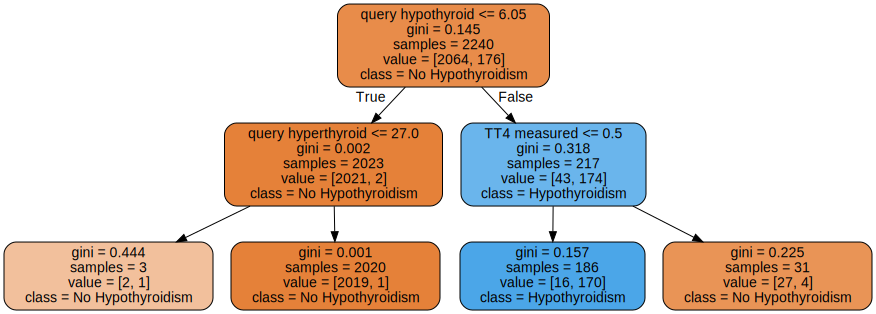

In [33]:
feature_names = list(data_train)[:-1]

dot_data = tree.export_graphviz(dt_model, out_file=None,
                         feature_names=feature_names,  
                         class_names=['No Hypothyroidism','Hypothyroidism'],
                         filled=True, rounded=True,
                         max_depth=4) 

graph = graphviz.Source(dot_data)
graph

In [16]:
i = 0
for label in list(data_train):
  print(i, label)
  i += 1

0 Age
1 Sex
2 On thyroxine
3 query on thyroxine
4 on antithyroid medication
5 sick
6 pregnant
7 thyroid surgery
8 I131 treatment
9 query hypothyroid
10 query hyperthyroid
11 lithium
12 goitre
13 tumor
14 psych
15 TSH measured
16 TSH
17 T3 measured
18 T3
19 TT4 measured
20 TT4
21 T4U measured
22 T4u
23 FTI measured
24 FTI
25 referral source
26 class


In [0]:
# SVM
from sklearn.svm import SVC
svm_model = SVC(gamma = .0005, probability = True)

y_val_proba = classifier_predictions(svm_model, data_train, data_val)

In [0]:
#Nearest Neighbors
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


def euclidean_dist(new_datum, other_datum):

    inner_val = 0.0
    
    for g in range(new_datum.shape[0]):
        inner_val += (new_datum[g]- other_datum[g]) ** 2
    
    distance = math.sqrt(inner_val)
    return(distance)

## 6. Evaluate your model

### Confusion Matrix Metric

In [34]:
from sklearn.metrics import confusion_matrix
import graphviz 
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# evaluate on validation set
y_val = data_val['class']

# This is exctly the first metric you'll be evaluated on!
# Note: this will only work on the binary case -- let us know if you get to the multi-class case

def cm_metric(y_true,y_prob):
    
    # predict the class with the greatest probability
    y_val_predict = [np.argmax(y) for y in y_prob]

    # calculate the confusion matrix
    cm = confusion_matrix(y_true, y_val_predict)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm_norm)
    return sum(sum(np.multiply(cm_norm,np.array([[1, -2], [-2, 1]]))))

#cm=
  
print('Confusion Matrix Metric: ',cm_metric(y_val,y_val_proba))
#score = cm.
#print("score:", )


[[1.         0.        ]
 [0.02272727 0.97727273]]
Confusion Matrix Metric:  1.9318181818181819


### AUC

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, threshold = roc_curve(y_val, y_val_proba[:,1])
roc_auc = auc(fpr, tpr)
print('AUC: ',roc_auc)



AUC:  0.9997797744890767


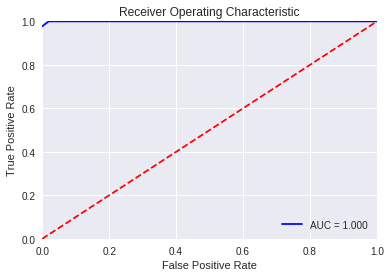

In [0]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 7. Apply to test data
Once you're happy with your model, you should go through the same procedure again except:
* train with ALL the training data (re-combine with training and validation)
* test on test data (you won't be able to evaluate -- that's for us to do!)

In [21]:
train_url = "https://raw.githubusercontent.com/BeaverWorksMedlytics/datasets/master/allhypo.train.data.csv"
test_url = "https://raw.githubusercontent.com/BeaverWorksMedlytics/datasets/master/allhypo.test.data.csv"

data_train = po.read_csv(train_url) 
data_test = po.read_csv(test_url)   # this will not have a 'class' column!

# format the wonky class labels
data_train = format_class_labels(data_train)

# deal with question marks
data_train = handle_questions(data_train)
data_test = handle_questions(data_test)

# drop uninformative columns
drop_columns = get_uninformative_columns(data_train)
data_train=data_train.drop(drop_columns,axis=1)
data_test=data_test.drop(drop_columns,axis=1)

# format data
data_train = format_data(data_train, numeric_columns)
data_test = format_data(data_test, numeric_columns)

# train and apply your classifier
y_test_proba = classifier_predictions(dt_model, data_train, data_test)

In [25]:
y_test_proba[0:100]

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.03211009, 0.96788991],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.03211009, 0.96788991],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.

## 8. Submit your attempt!

Once you've run on the test data, send a pickle file containing your predictions contained a pandas dataframe.  This pandas dataframe will contain two columns for your binary classifier (or 4 columns for the multiclass classifier) that looks like this (*pay attention to the column names!*):

|   | 0 | 1   |
|---|---|------|
| 0 | $p_{0,0}$ | $p_{0,1}$|
| 1 | $p_{1,0}$ | $p_{1,1}$|
| 2 | $p_{2,0}$ | $p_{2,1}$|
| ... | ... | ...|
| N | $p_{N,0}$ | $p_{N,1}$|

where $p_{i,j}$ corresponds to the probability of data point $i$ belonging to class $j$.

In [26]:
from google.colab import files
import pickle

# create a pickle file (this will save to the Google cloud)
prediction_pickle_path = 'claws_week1_attempt1.pkl'
prediction_pickle = open(prediction_pickle_path, 'wb')
pickle.dump(y_test_proba, prediction_pickle)

# download the pickle file and save it somewhere to your computer, and email it to 
files.download(prediction_pickle_path)
prediction_pickle.close()

# Moving to the Next Level

For those that finish early, remember how I converted the class values into simply "negative" and "positive"? Now try tackling the multiclass classifier (predicting the different types of positive hypothyroid cases instead of simply negative or positive)! 

The same rules apply!  (Note: for the multiclass problem, the AUC calculation will be the micro-average over your classes.)

(And for those that also finish the multiclass classifer, see Lyle for further instructions).

## Looking at positive hypothyroid cases



In [0]:
filtered_dataframe_by_class = data_train[data_train['class'] > 0]
filtered_dataframe_by_class.head(30)

,Age,Sex,On thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,T3 measured,T3,TT4 measured,TT4,T4U measured,T4u,FTI measured,FTI,referral source,class
346,75.0,0,0,0,0,0,0,0,0,0,...,1,1.9,1,79.0,1,1.00,1,80.0,0,1
1125,28.0,0,0,0,0,0,0,0,0,0,...,1,2.1,1,50.0,1,1.10,1,46.0,0,1
2688,50.0,0,1,0,0,0,0,0,1,0,...,0,2.0,1,13.0,1,1.18,1,11.0,0,1
935,16.0,0,0,0,0,0,0,0,0,0,...,0,2.0,1,98.0,1,1.30,1,76.0,0,1
785,44.0,1,0,0,0,0,0,0,0,0,...,1,0.8,1,86.0,1,0.66,1,130.0,0,1
1167,68.0,1,0,0,0,0,0,0,0,0,...,1,2.0,1,81.0,1,1.01,1,81.0,0,1
899,84.0,0,0,0,0,0,0,0,0,0,...,1,0.7,1,52.0,1,1.11,1,47.0,0,1
1411,64.0,0,0,0,0,0,0,0,0,0,...,1,1.2,1,67.0,1,0.75,1,89.0,0,1
2378,68.0,0,0,0,0,0,0,0,0,1,...,1,1.4,1,111.0,1,1.20,1,93.0,0,1
368,29.0,0,0,0,0,0,0,1,0,0,...,0,2.0,1,63.0,1,1.20,1,53.0,0,1
